In [1]:
# connect to google colab
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
# COLAB CONFIG
# change colab flag to false if train using jupyter notebook
COLAB_FLAG = True
COLAB_FILEPATH = './drive/My Drive/TIL2021/competition/SC' if COLAB_FLAG == True else './'
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [4]:
def get_score(pred_path):
    ground = pd.read_csv(f'{COLAB_FILEPATH}/submission/sc_ground_truth.csv', names=['file', 'truth'])
    pred = pd.read_csv(f'{COLAB_FILEPATH}/submission/{pred_path}.csv', names=['file', 'pred'])
    ground['pred'] = pred['pred']
    # Get the F1 and accuracy
    print(classification_report(list(ground['truth']), list(ground['pred']), digits=4))
    print()
    # Get confusion matrix
    cm_sns = pd.crosstab(ground['truth'], ground['pred'], rownames=['Actual'], colnames=['Predicted'])
    plt.subplots(figsize=(12,10))
    sns.heatmap(cm_sns, annot=True, fmt='d', cmap='YlGnBu_r')
    plt.show()

## 5-fold method | TM-5 | FM-3

              precision    recall  f1-score   support

        bird     0.9184    0.9000    0.9091        50
       eight     0.7963    0.8776    0.8350        49
      falcon     0.8846    0.9388    0.9109        49
        five     0.9048    0.7755    0.8352        49
        four     0.9184    0.8824    0.9000        51
        nine     0.9020    0.8846    0.8932        52
         one     0.9556    0.8431    0.8958        51
       seven     0.8679    0.9200    0.8932        50
         six     0.9200    0.9200    0.9200        50
       snake     0.9556    0.8958    0.9247        48
       three     0.8627    0.8462    0.8544        52
         two     0.7500    0.8750    0.8077        48
        zero     0.9038    0.9400    0.9216        50

    accuracy                         0.8844       649
   macro avg     0.8877    0.8845    0.8847       649
weighted avg     0.8881    0.8844    0.8849       649




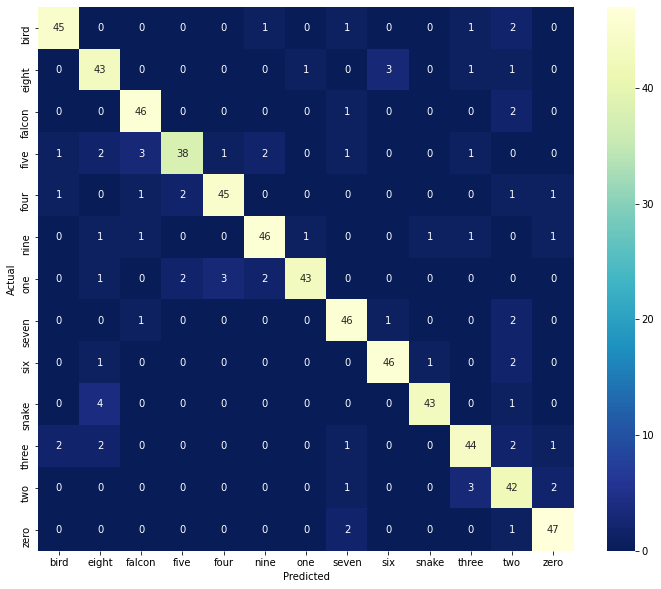

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.8846    0.9200    0.9020        50
       eight     0.8182    0.9184    0.8654        49
      falcon     0.8936    0.8571    0.8750        49
        five     0.8837    0.7755    0.8261        49
        four     0.9038    0.9216    0.9126        51
        nine     0.8704    0.9038    0.8868        52
         one     0.9556    0.8431    0.8958        51
       seven     0.8393    0.9400    0.8868        50
         six     0.9574    0.9000    0.9278        50
       snake     0.9111    0.8542    0.8817        48
       three     0.9149    0.8269    0.8687        52
         two     0.7679    0.8958    0.8269        48
        zero     0.9000    0.9000    0.9000        50

    accuracy                         0.8814       649
   macro avg     0.8847    0.8813    0.8812       649
weighted avg     0.8852    0.8814    0.8815       649




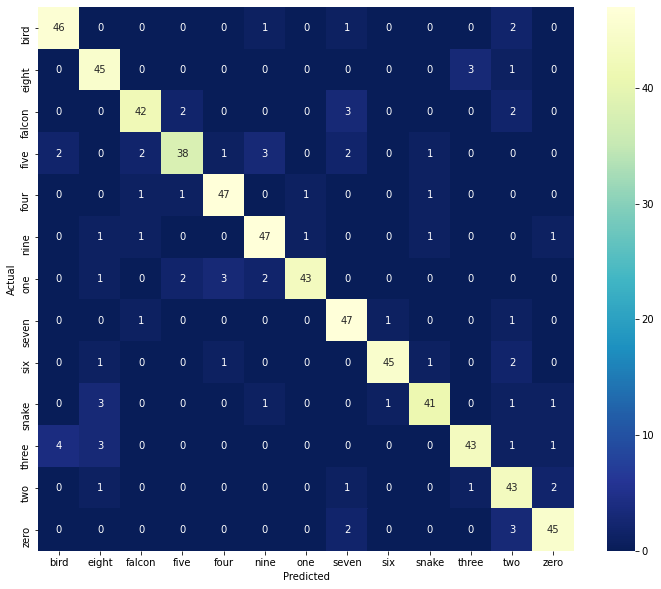

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 128, 2, 64, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.8431    0.8600    0.8515        50
       eight     0.7736    0.8367    0.8039        49
      falcon     0.8235    0.8571    0.8400        49
        five     0.8780    0.7347    0.8000        49
        four     0.8491    0.8824    0.8654        51
        nine     0.9000    0.8654    0.8824        52
         one     0.8958    0.8431    0.8687        51
       seven     0.8000    0.8800    0.8381        50
         six     0.9388    0.9200    0.9293        50
       snake     0.8367    0.8542    0.8454        48
       three     0.8400    0.8077    0.8235        52
         two     0.7143    0.7292    0.7216        48
        zero     0.8800    0.8800    0.8800        50

    accuracy                         0.8428       649
   macro avg     0.8441    0.8423    0.8423       649
weighted avg     0.8448    0.8428    0.8429       649




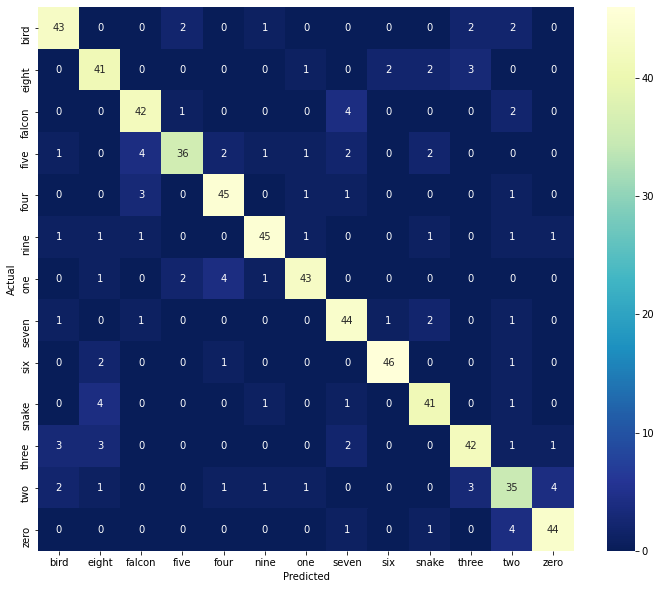

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 64, 2, 64, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9167    0.8800    0.8980        50
       eight     0.8491    0.9184    0.8824        49
      falcon     0.9167    0.8980    0.9072        49
        five     0.9024    0.7551    0.8222        49
        four     0.8545    0.9216    0.8868        51
        nine     0.9038    0.9038    0.9038        52
         one     0.8958    0.8431    0.8687        51
       seven     0.8246    0.9400    0.8785        50
         six     0.9792    0.9400    0.9592        50
       snake     0.9783    0.9375    0.9574        48
       three     0.9778    0.8462    0.9072        52
         two     0.8070    0.9583    0.8762        48
        zero     0.9412    0.9600    0.9505        50

    accuracy                         0.8998       649
   macro avg     0.9036    0.9002    0.8999       649
weighted avg     0.9039    0.8998    0.8999       649




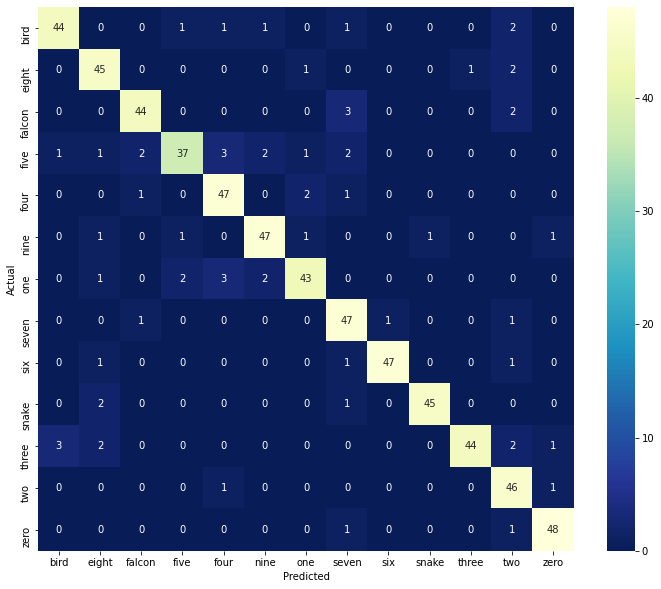

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 3, 64, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9038    0.9400    0.9216        50
       eight     0.8679    0.9388    0.9020        49
      falcon     0.8980    0.8980    0.8980        49
        five     0.9286    0.7959    0.8571        49
        four     0.9200    0.9020    0.9109        51
        nine     0.9216    0.9038    0.9126        52
         one     0.9362    0.8627    0.8980        51
       seven     0.8103    0.9400    0.8704        50
         six     0.9574    0.9000    0.9278        50
       snake     0.9565    0.9167    0.9362        48
       three     0.9375    0.8654    0.9000        52
         two     0.7593    0.8542    0.8039        48
        zero     0.8846    0.9200    0.9020        50

    accuracy                         0.8952       649
   macro avg     0.8986    0.8952    0.8954       649
weighted avg     0.8991    0.8952    0.8957       649




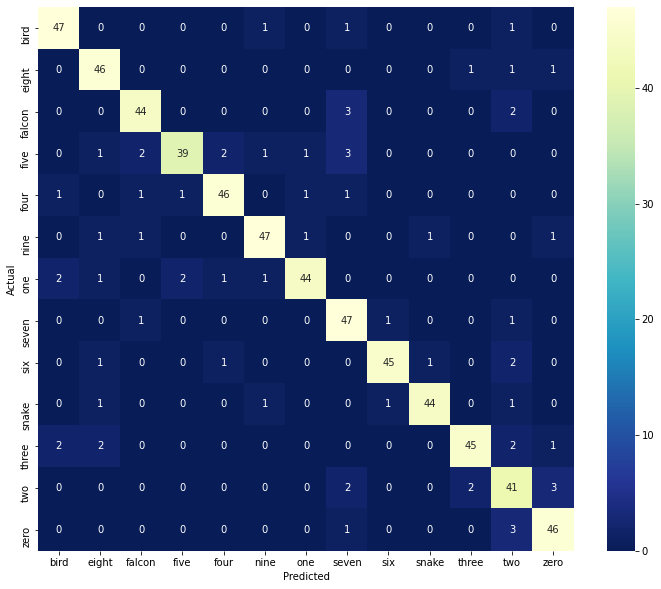

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9348    0.8600    0.8958        50
       eight     0.8679    0.9388    0.9020        49
      falcon     0.9200    0.9388    0.9293        49
        five     0.9048    0.7755    0.8352        49
        four     0.9787    0.9020    0.9388        51
        nine     0.8727    0.9231    0.8972        52
         one     0.8980    0.8627    0.8800        51
       seven     0.8679    0.9200    0.8932        50
         six     0.9792    0.9400    0.9592        50
       snake     0.9375    0.9375    0.9375        48
       three     0.8846    0.8846    0.8846        52
         two     0.7455    0.8542    0.7961        48
        zero     0.8824    0.9000    0.8911        50

    accuracy                         0.8952       649
   macro avg     0.8980    0.8952    0.8954       649
weighted avg     0.8983    0.8952    0.8956       649




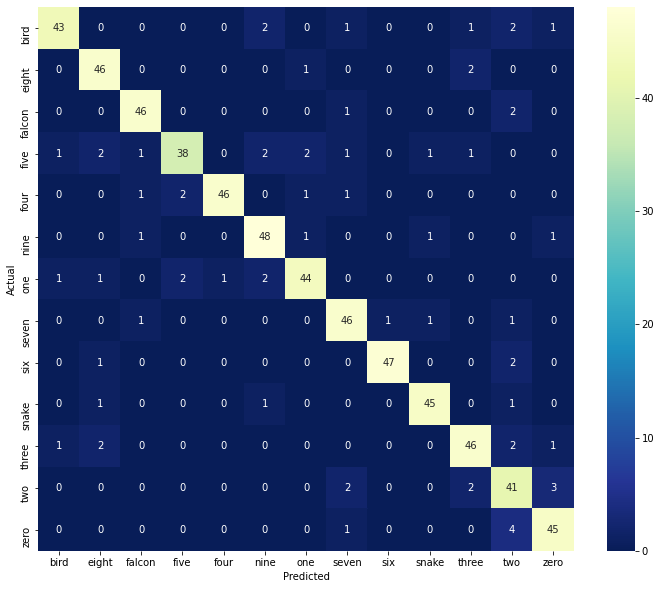

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 128, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## Change optimizer

              precision    recall  f1-score   support

        bird     0.7755    0.7600    0.7677        50
       eight     0.7321    0.8367    0.7810        49
      falcon     0.8298    0.7959    0.8125        49
        five     0.7907    0.6939    0.7391        49
        four     0.7708    0.7255    0.7475        51
        nine     0.8085    0.7308    0.7677        52
         one     0.7647    0.7647    0.7647        51
       seven     0.7541    0.9200    0.8288        50
         six     0.8542    0.8200    0.8367        50
       snake     0.8000    0.7500    0.7742        48
       three     0.7727    0.6538    0.7083        52
         two     0.5714    0.6667    0.6154        48
        zero     0.7778    0.8400    0.8077        50

    accuracy                         0.7658       649
   macro avg     0.7694    0.7660    0.7655       649
weighted avg     0.7700    0.7658    0.7657       649




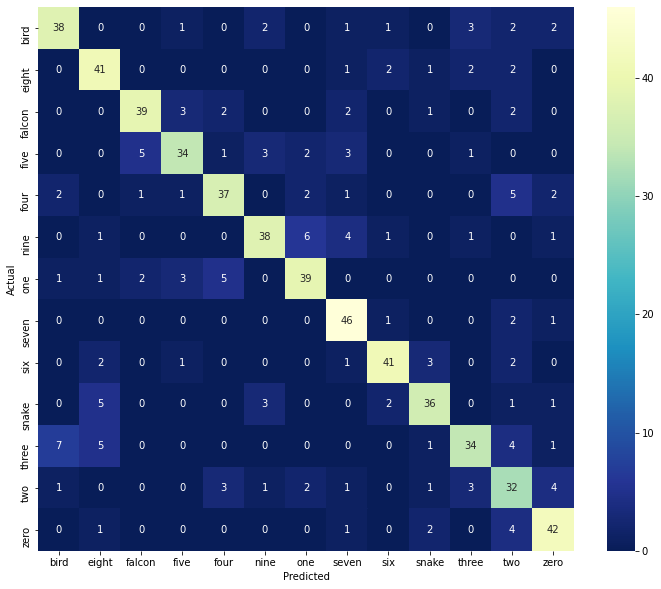

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'sgd', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9184    0.9000    0.9091        50
       eight     0.8936    0.8571    0.8750        49
      falcon     0.8824    0.9184    0.9000        49
        five     0.9070    0.7959    0.8478        49
        four     0.9400    0.9216    0.9307        51
        nine     0.8679    0.8846    0.8762        52
         one     0.8958    0.8431    0.8687        51
       seven     0.8393    0.9400    0.8868        50
         six     0.9184    0.9000    0.9091        50
       snake     0.8980    0.9167    0.9072        48
       three     0.8958    0.8269    0.8600        52
         two     0.7455    0.8542    0.7961        48
        zero     0.9020    0.9200    0.9109        50

    accuracy                         0.8829       649
   macro avg     0.8849    0.8830    0.8829       649
weighted avg     0.8853    0.8829    0.8831       649




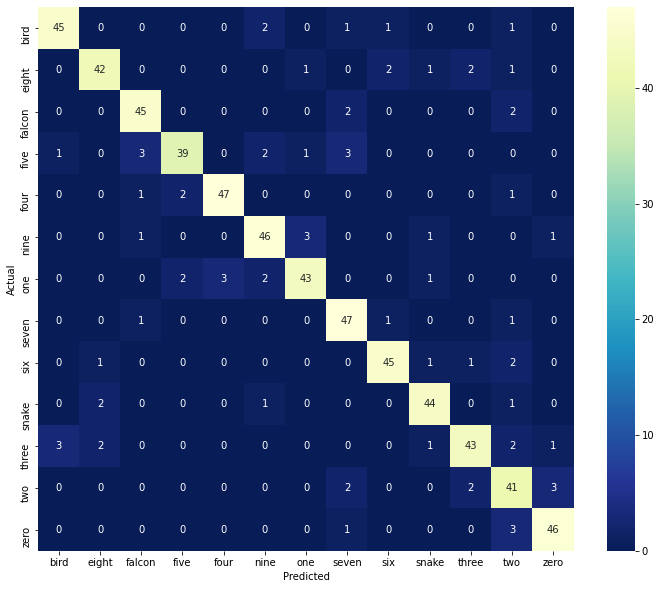

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adamw', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9388    0.9200    0.9293        50
       eight     0.8182    0.9184    0.8654        49
      falcon     0.9184    0.9184    0.9184        49
        five     0.9091    0.8163    0.8602        49
        four     0.9216    0.9216    0.9216        51
        nine     0.9375    0.8654    0.9000        52
         one     0.9184    0.8824    0.9000        51
       seven     0.9216    0.9400    0.9307        50
         six     1.0000    0.9200    0.9583        50
       snake     0.9149    0.8958    0.9053        48
       three     0.9038    0.9038    0.9038        52
         two     0.7627    0.9375    0.8411        48
        zero     0.9388    0.9200    0.9293        50

    accuracy                         0.9045       649
   macro avg     0.9080    0.9046    0.9049       649
weighted avg     0.9086    0.9045    0.9052       649




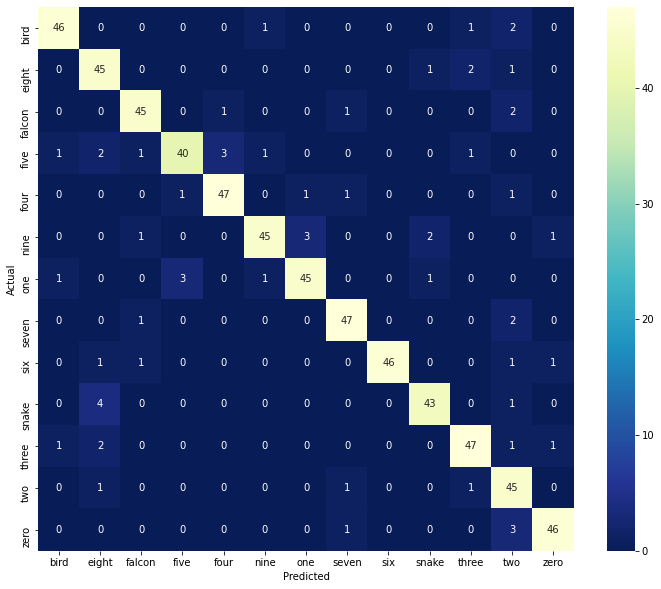

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.8627    0.8800    0.8713        50
       eight     0.8235    0.8571    0.8400        49
      falcon     0.9333    0.8571    0.8936        49
        five     0.8409    0.7551    0.7957        49
        four     0.8679    0.9020    0.8846        51
        nine     0.9038    0.9038    0.9038        52
         one     0.9149    0.8431    0.8776        51
       seven     0.7619    0.9600    0.8496        50
         six     0.9583    0.9200    0.9388        50
       snake     0.9333    0.8750    0.9032        48
       three     0.9070    0.7500    0.8211        52
         two     0.7368    0.8750    0.8000        48
        zero     0.8800    0.8800    0.8800        50

    accuracy                         0.8659       649
   macro avg     0.8711    0.8660    0.8661       649
weighted avg     0.8716    0.8659    0.8663       649




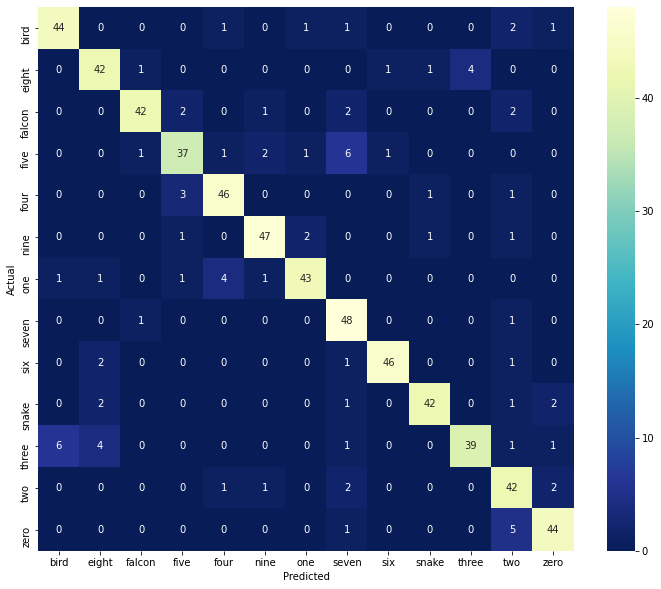

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adadelta', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.8679    0.9200    0.8932        50
       eight     0.8824    0.9184    0.9000        49
      falcon     0.9130    0.8571    0.8842        49
        five     0.8837    0.7755    0.8261        49
        four     0.9167    0.8627    0.8889        51
        nine     0.9400    0.9038    0.9216        52
         one     0.9149    0.8431    0.8776        51
       seven     0.7705    0.9400    0.8468        50
         six     0.9583    0.9200    0.9388        50
       snake     0.9020    0.9583    0.9293        48
       three     0.9375    0.8654    0.9000        52
         two     0.7593    0.8542    0.8039        48
        zero     0.9388    0.9200    0.9293        50

    accuracy                         0.8875       649
   macro avg     0.8911    0.8876    0.8877       649
weighted avg     0.8919    0.8875    0.8880       649




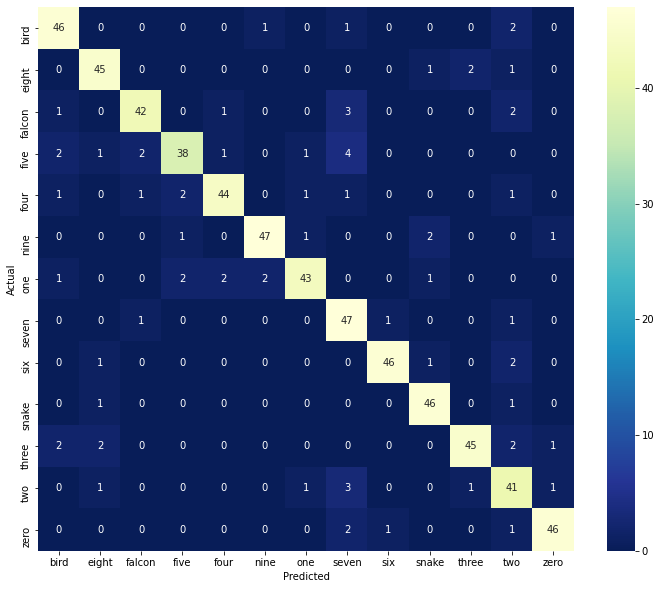

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adamax', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 5-fold method | TM-7 | FM-3

              precision    recall  f1-score   support

        bird     0.8958    0.8600    0.8776        50
       eight     0.8824    0.9184    0.9000        49
      falcon     0.9167    0.8980    0.9072        49
        five     0.8837    0.7755    0.8261        49
        four     0.8462    0.8627    0.8544        51
        nine     0.8868    0.9038    0.8952        52
         one     0.8958    0.8431    0.8687        51
       seven     0.8727    0.9600    0.9143        50
         six     0.9583    0.9200    0.9388        50
       snake     0.9020    0.9583    0.9293        48
       three     0.9348    0.8269    0.8776        52
         two     0.7544    0.8958    0.8190        48
        zero     0.9388    0.9200    0.9293        50

    accuracy                         0.8875       649
   macro avg     0.8899    0.8879    0.8875       649
weighted avg     0.8903    0.8875    0.8875       649




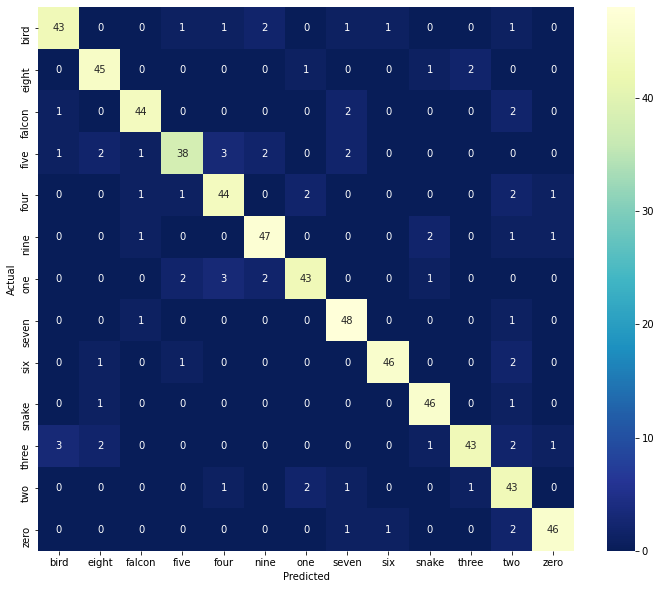

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 7, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9556    0.8600    0.9053        50
       eight     0.8654    0.9184    0.8911        49
      falcon     0.9200    0.9388    0.9293        49
        five     0.8776    0.8776    0.8776        49
        four     0.9200    0.9020    0.9109        51
        nine     0.9412    0.9231    0.9320        52
         one     0.9333    0.8235    0.8750        51
       seven     0.8421    0.9600    0.8972        50
         six     0.9362    0.8800    0.9072        50
       snake     0.8958    0.8958    0.8958        48
       three     0.8627    0.8462    0.8544        52
         two     0.7925    0.8750    0.8317        48
        zero     0.9216    0.9400    0.9307        50

    accuracy                         0.8952       649
   macro avg     0.8972    0.8954    0.8952       649
weighted avg     0.8977    0.8952    0.8954       649




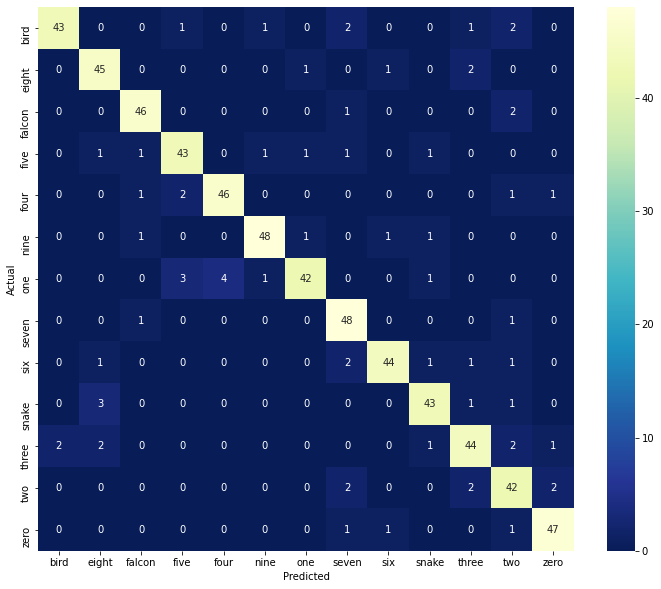

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 7, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adamw', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9167    0.8800    0.8980        50
       eight     0.9149    0.8776    0.8958        49
      falcon     0.8824    0.9184    0.9000        49
        five     0.9268    0.7755    0.8444        49
        four     0.9184    0.8824    0.9000        51
        nine     0.8868    0.9038    0.8952        52
         one     0.9167    0.8627    0.8889        51
       seven     0.8070    0.9200    0.8598        50
         six     0.9388    0.9200    0.9293        50
       snake     0.8980    0.9167    0.9072        48
       three     0.8491    0.8654    0.8571        52
         two     0.8077    0.8750    0.8400        48
        zero     0.9423    0.9800    0.9608        50

    accuracy                         0.8906       649
   macro avg     0.8927    0.8906    0.8905       649
weighted avg     0.8928    0.8906    0.8906       649




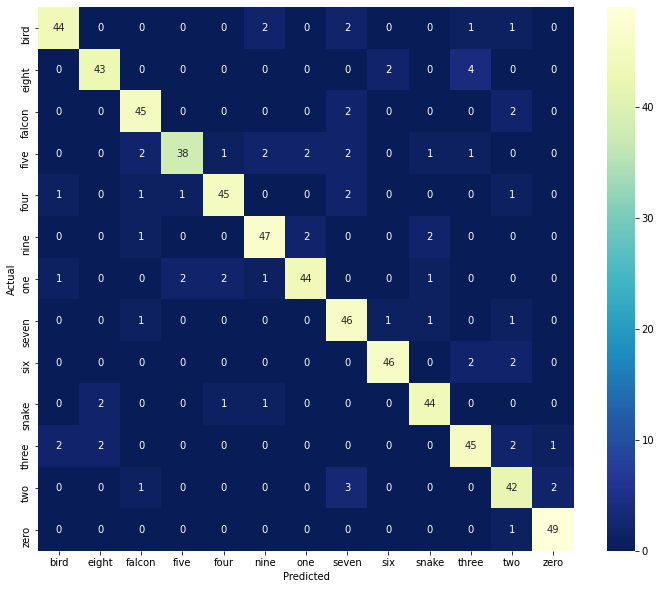

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 7, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.8958    0.8600    0.8776        50
       eight     0.9038    0.9592    0.9307        49
      falcon     0.8627    0.8980    0.8800        49
        five     0.9268    0.7755    0.8444        49
        four     0.8600    0.8431    0.8515        51
        nine     0.9200    0.8846    0.9020        52
         one     0.9167    0.8627    0.8889        51
       seven     0.7966    0.9400    0.8624        50
         six     0.9375    0.9000    0.9184        50
       snake     0.8824    0.9375    0.9091        48
       three     0.9778    0.8462    0.9072        52
         two     0.7895    0.9375    0.8571        48
        zero     0.9388    0.9200    0.9293        50

    accuracy                         0.8891       649
   macro avg     0.8930    0.8896    0.8891       649
weighted avg     0.8936    0.8891    0.8892       649




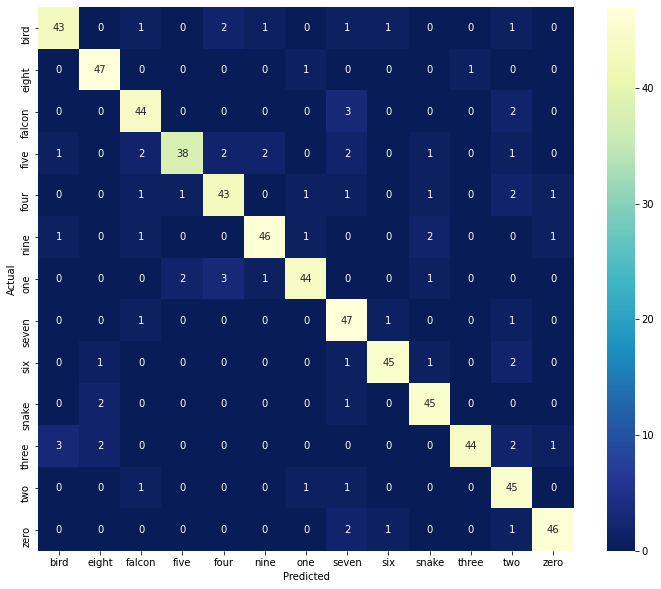

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 7, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adamax', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 5-fold method | TM-5 | FM-3 | Dropout

              precision    recall  f1-score   support

        bird     0.8679    0.9200    0.8932        50
       eight     0.8182    0.9184    0.8654        49
      falcon     0.8776    0.8776    0.8776        49
        five     0.8864    0.7959    0.8387        49
        four     0.9184    0.8824    0.9000        51
        nine     0.8958    0.8269    0.8600        52
         one     0.9130    0.8235    0.8660        51
       seven     0.7705    0.9400    0.8468        50
         six     0.9362    0.8800    0.9072        50
       snake     0.8936    0.8750    0.8842        48
       three     0.9348    0.8269    0.8776        52
         two     0.8269    0.8958    0.8600        48
        zero     0.9038    0.9400    0.9216        50

    accuracy                         0.8767       649
   macro avg     0.8802    0.8771    0.8768       649
weighted avg     0.8808    0.8767    0.8769       649




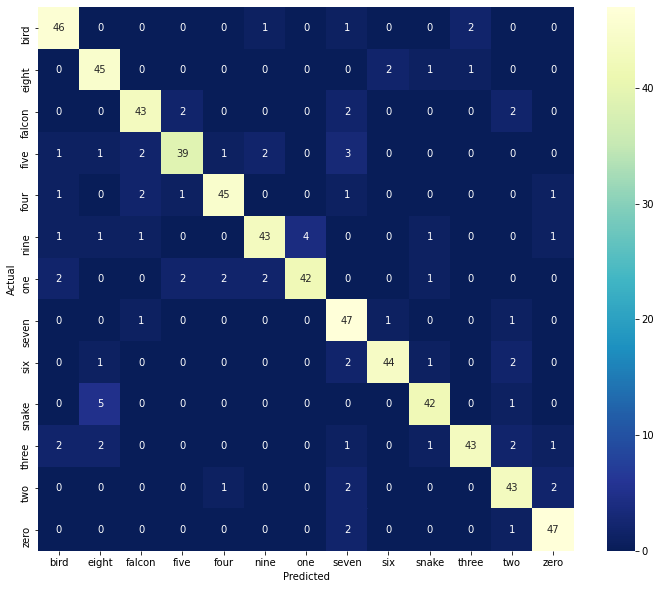

In [ ]:
# configuration
DROP_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9375    0.9000    0.9184        50
       eight     0.8462    0.8980    0.8713        49
      falcon     0.9020    0.9388    0.9200        49
        five     0.9231    0.7347    0.8182        49
        four     0.8824    0.8824    0.8824        51
        nine     0.8868    0.9038    0.8952        52
         one     0.8936    0.8235    0.8571        51
       seven     0.8246    0.9400    0.8785        50
         six     0.9375    0.9000    0.9184        50
       snake     0.9184    0.9375    0.9278        48
       three     0.9038    0.9038    0.9038        52
         two     0.7719    0.9167    0.8381        48
        zero     0.9778    0.8800    0.9263        50

    accuracy                         0.8891       649
   macro avg     0.8927    0.8892    0.8889       649
weighted avg     0.8930    0.8891    0.8890       649




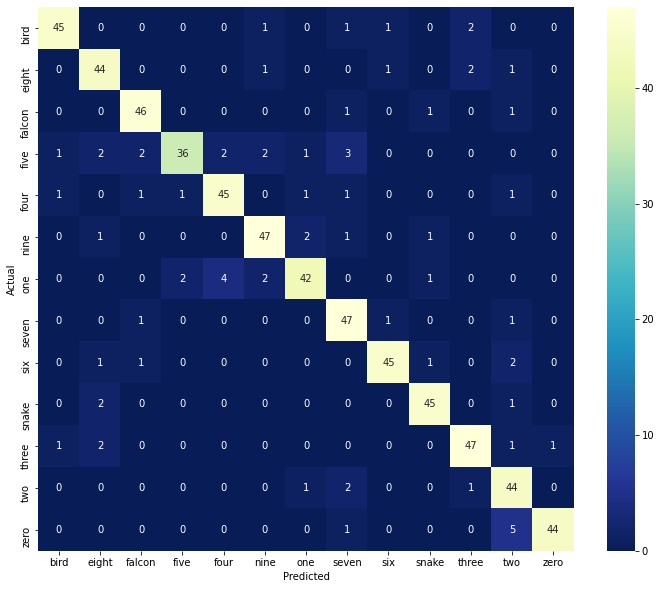

In [ ]:
# configuration
DROP_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adamw', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9388    0.9200    0.9293        50
       eight     0.8824    0.9184    0.9000        49
      falcon     0.9167    0.8980    0.9072        49
        five     0.9286    0.7959    0.8571        49
        four     0.8909    0.9608    0.9245        51
        nine     0.9231    0.9231    0.9231        52
         one     1.0000    0.8627    0.9263        51
       seven     0.8393    0.9400    0.8868        50
         six     0.9592    0.9400    0.9495        50
       snake     0.9388    0.9583    0.9485        48
       three     0.9375    0.8654    0.9000        52
         two     0.7586    0.9167    0.8302        48
        zero     0.9375    0.9000    0.9184        50

    accuracy                         0.9076       649
   macro avg     0.9116    0.9076    0.9078       649
weighted avg     0.9123    0.9076    0.9080       649




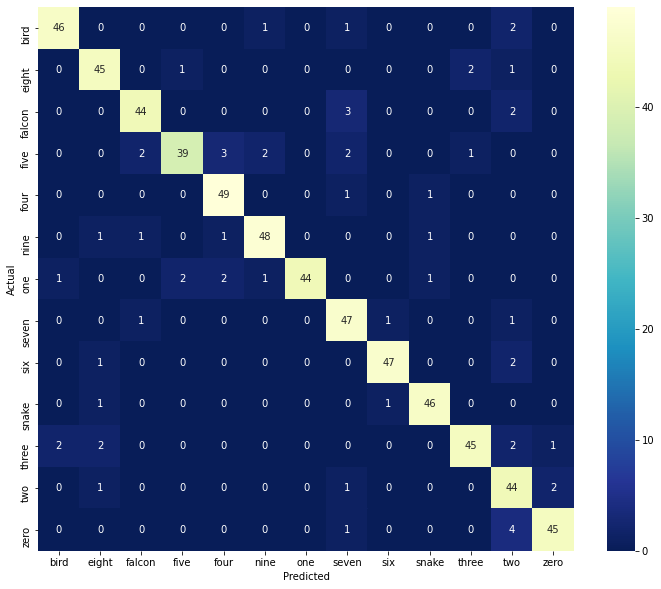

In [ ]:
# configuration
DROP_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.8800    0.8800    0.8800        50
       eight     0.8980    0.8980    0.8980        49
      falcon     0.8571    0.8571    0.8571        49
        five     0.8636    0.7755    0.8172        49
        four     0.8824    0.8824    0.8824        51
        nine     0.8868    0.9038    0.8952        52
         one     0.9149    0.8431    0.8776        51
       seven     0.8246    0.9400    0.8785        50
         six     0.9020    0.9200    0.9109        50
       snake     0.9149    0.8958    0.9053        48
       three     0.8936    0.8077    0.8485        52
         two     0.7778    0.8750    0.8235        48
        zero     0.9200    0.9200    0.9200        50

    accuracy                         0.8767       649
   macro avg     0.8781    0.8768    0.8765       649
weighted avg     0.8785    0.8767    0.8766       649




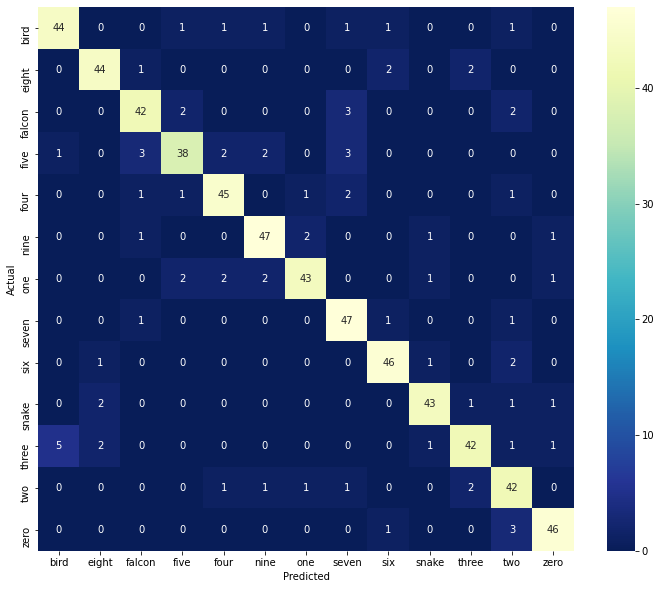

In [ ]:
# configuration
DROP_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 64, 'adamax', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 5-fold method | TM-3 | FM-3 

              precision    recall  f1-score   support

        bird     0.9200    0.9200    0.9200        50
       eight     0.8936    0.8571    0.8750        49
      falcon     0.8679    0.9388    0.9020        49
        five     0.9268    0.7755    0.8444        49
        four     0.9184    0.8824    0.9000        51
        nine     0.9412    0.9231    0.9320        52
         one     0.9149    0.8431    0.8776        51
       seven     0.8571    0.9600    0.9057        50
         six     0.8846    0.9200    0.9020        50
       snake     0.8980    0.9167    0.9072        48
       three     0.8750    0.8077    0.8400        52
         two     0.7679    0.8958    0.8269        48
        zero     0.9400    0.9400    0.9400        50

    accuracy                         0.8906       649
   macro avg     0.8927    0.8908    0.8902       649
weighted avg     0.8932    0.8906    0.8904       649




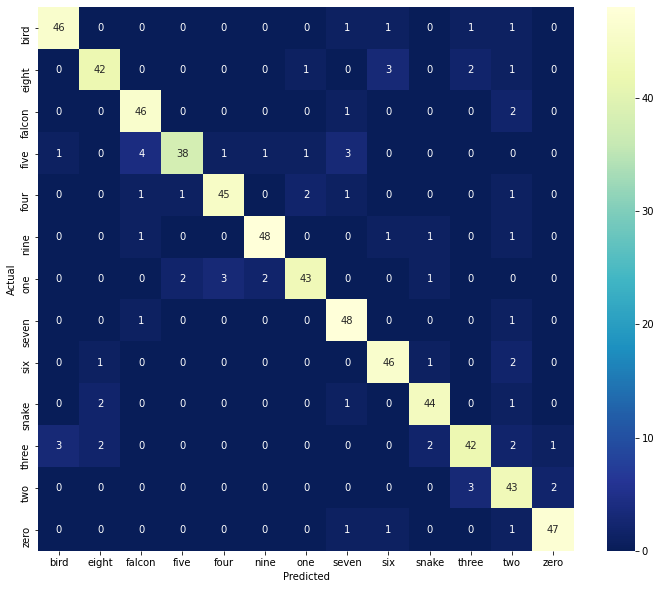

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 3, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adam', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9184    0.9000    0.9091        50
       eight     0.8600    0.8776    0.8687        49
      falcon     0.8571    0.8571    0.8571        49
        five     0.8936    0.8571    0.8750        49
        four     0.9592    0.9216    0.9400        51
        nine     0.9400    0.9038    0.9216        52
         one     0.9574    0.8824    0.9184        51
       seven     0.8364    0.9200    0.8762        50
         six     0.8868    0.9400    0.9126        50
       snake     0.9375    0.9375    0.9375        48
       three     0.8958    0.8269    0.8600        52
         two     0.7818    0.8958    0.8350        48
        zero     0.9592    0.9400    0.9495        50

    accuracy                         0.8968       649
   macro avg     0.8987    0.8969    0.8970       649
weighted avg     0.8994    0.8968    0.8972       649




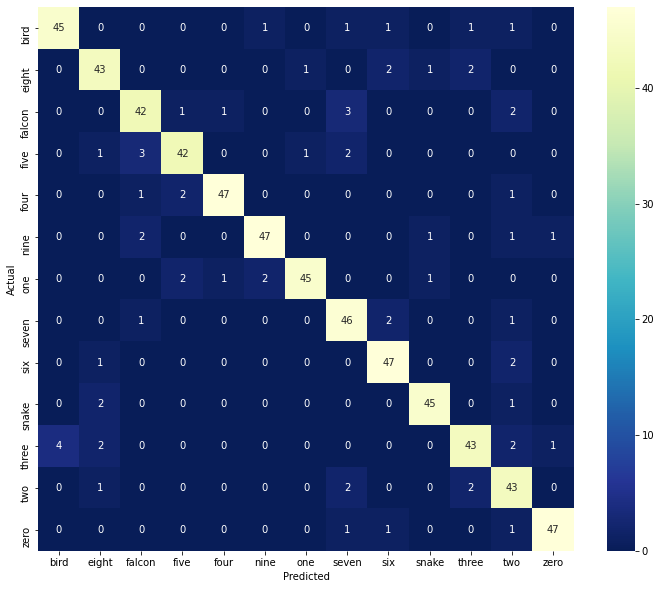

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 3, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adamw', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9388    0.9200    0.9293        50
       eight     0.8704    0.9592    0.9126        49
      falcon     0.9184    0.9184    0.9184        49
        five     0.8889    0.8163    0.8511        49
        four     0.9111    0.8039    0.8542        51
        nine     0.9200    0.8846    0.9020        52
         one     0.9149    0.8431    0.8776        51
       seven     0.7705    0.9400    0.8468        50
         six     0.9583    0.9200    0.9388        50
       snake     0.9574    0.9375    0.9474        48
       three     0.9200    0.8846    0.9020        52
         two     0.7593    0.8542    0.8039        48
        zero     0.9000    0.9000    0.9000        50

    accuracy                         0.8906       649
   macro avg     0.8945    0.8909    0.8911       649
weighted avg     0.8949    0.8906    0.8911       649




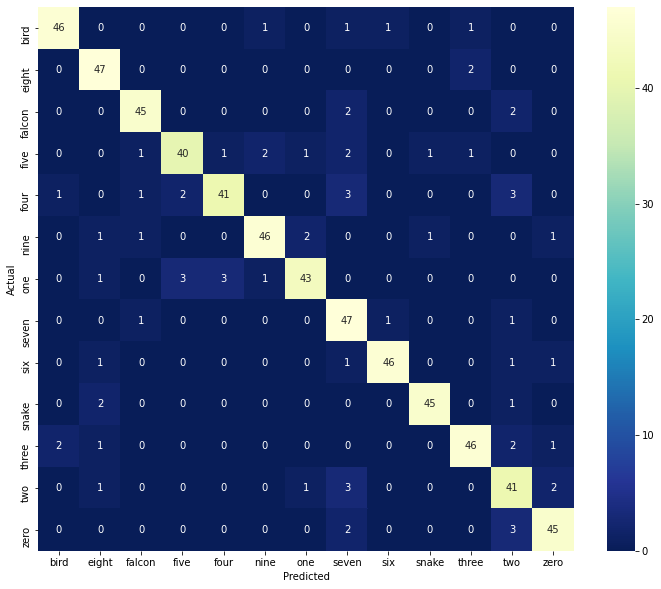

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 3, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9778    0.8800    0.9263        50
       eight     0.8824    0.9184    0.9000        49
      falcon     0.8980    0.8980    0.8980        49
        five     0.9111    0.8367    0.8723        49
        four     0.8600    0.8431    0.8515        51
        nine     0.8704    0.9038    0.8868        52
         one     0.9348    0.8431    0.8866        51
       seven     0.8571    0.9600    0.9057        50
         six     0.9574    0.9000    0.9278        50
       snake     0.8800    0.9167    0.8980        48
       three     0.8824    0.8654    0.8738        52
         two     0.7963    0.8958    0.8431        48
        zero     0.9020    0.9200    0.9109        50

    accuracy                         0.8906       649
   macro avg     0.8930    0.8909    0.8908       649
weighted avg     0.8933    0.8906    0.8908       649




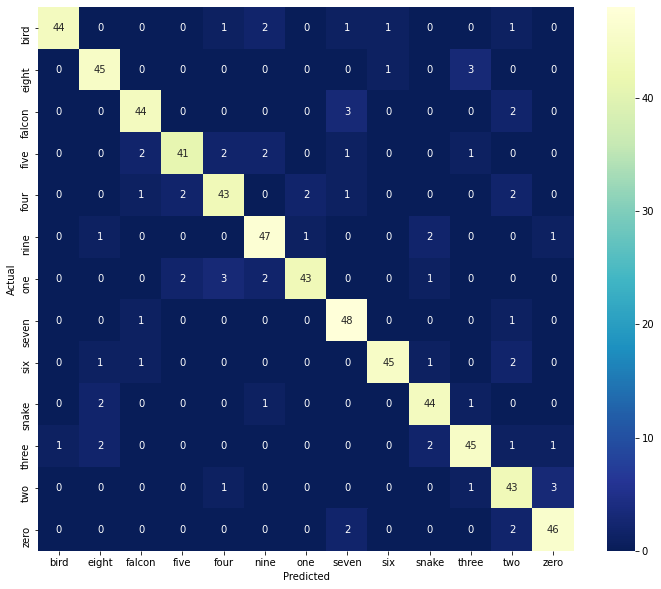

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 3, 3
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adamax', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 5-fold method | TM-5 | FM-5 

              precision    recall  f1-score   support

        bird     0.9375    0.9000    0.9184        50
       eight     0.9200    0.9388    0.9293        49
      falcon     0.9200    0.9388    0.9293        49
        five     0.9545    0.8571    0.9032        49
        four     0.9074    0.9608    0.9333        51
        nine     0.9400    0.9038    0.9216        52
         one     0.9375    0.8824    0.9091        51
       seven     0.9200    0.9200    0.9200        50
         six     0.9574    0.9000    0.9278        50
       snake     0.9200    0.9583    0.9388        48
       three     0.8800    0.8462    0.8627        52
         two     0.7586    0.9167    0.8302        48
        zero     0.9600    0.9600    0.9600        50

    accuracy                         0.9137       649
   macro avg     0.9164    0.9141    0.9141       649
weighted avg     0.9168    0.9137    0.9142       649




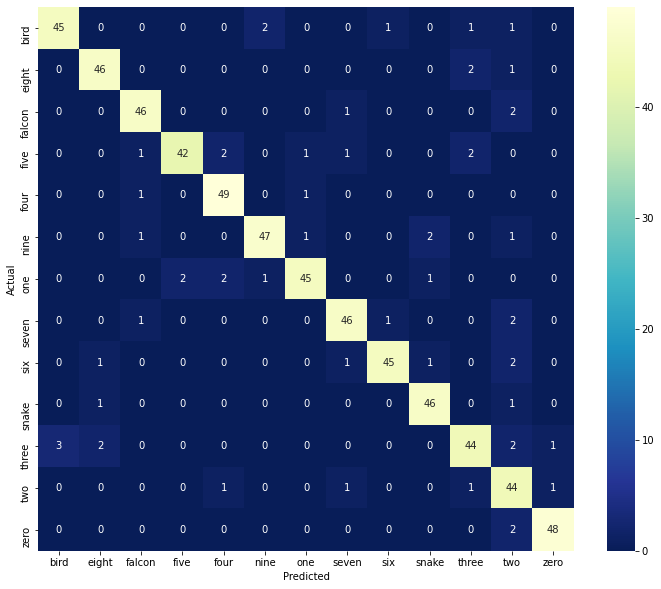

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 5-fold method | TM-5 | FM-7 

              precision    recall  f1-score   support

        bird     0.8958    0.8600    0.8776        50
       eight     0.8800    0.8980    0.8889        49
      falcon     0.9000    0.9184    0.9091        49
        five     0.9091    0.8163    0.8602        49
        four     0.9787    0.9020    0.9388        51
        nine     0.9216    0.9038    0.9126        52
         one     0.9184    0.8824    0.9000        51
       seven     0.8070    0.9200    0.8598        50
         six     0.9592    0.9400    0.9495        50
       snake     0.9000    0.9375    0.9184        48
       three     0.8958    0.8269    0.8600        52
         two     0.7931    0.9583    0.8679        48
        zero     0.9792    0.9400    0.9592        50

    accuracy                         0.8998       649
   macro avg     0.9029    0.9003    0.9001       649
weighted avg     0.9035    0.8998    0.9002       649




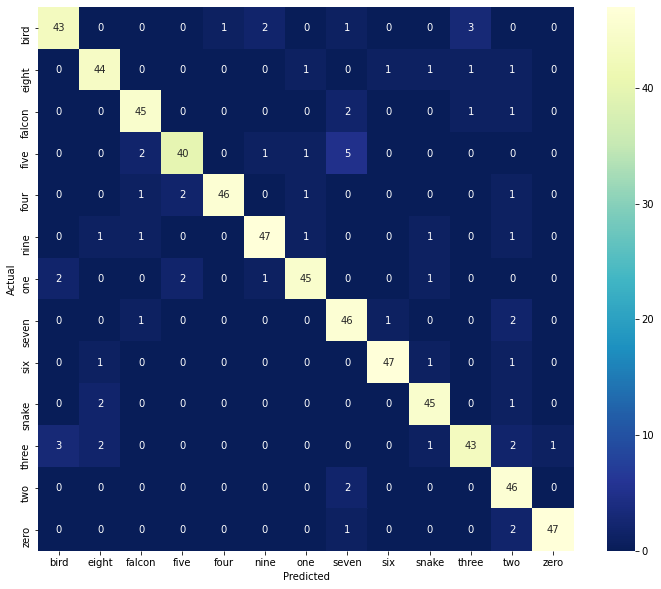

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 7
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 5-fold method | TM-5 | FM-5 | Dropout

              precision    recall  f1-score   support

        bird     0.9778    0.8800    0.9263        50
       eight     0.8800    0.8980    0.8889        49
      falcon     0.9388    0.9388    0.9388        49
        five     0.9091    0.8163    0.8602        49
        four     0.9216    0.9216    0.9216        51
        nine     0.8846    0.8846    0.8846        52
         one     0.9000    0.8824    0.8911        51
       seven     0.8393    0.9400    0.8868        50
         six     0.9200    0.9200    0.9200        50
       snake     0.8980    0.9167    0.9072        48
       three     0.8846    0.8846    0.8846        52
         two     0.8113    0.8958    0.8515        48
        zero     0.9375    0.9000    0.9184        50

    accuracy                         0.8983       649
   macro avg     0.9002    0.8984    0.8985       649
weighted avg     0.9004    0.8983    0.8985       649




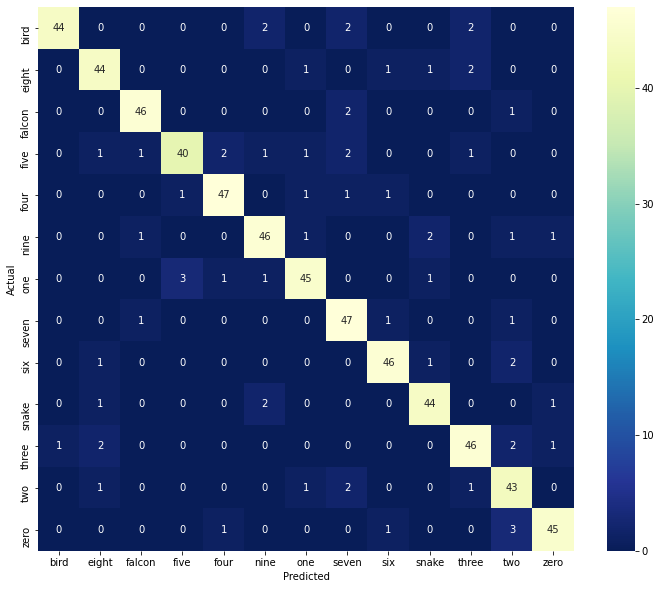

In [ ]:
# configuration
DROP_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

## 10-fold method | TM-5 | FM-5 

              precision    recall  f1-score   support

        bird     0.9592    0.9400    0.9495        50
       eight     0.8980    0.8980    0.8980        49
      falcon     0.8679    0.9388    0.9020        49
        five     0.9302    0.8163    0.8696        49
        four     0.8846    0.9020    0.8932        51
        nine     0.9038    0.9038    0.9038        52
         one     0.9556    0.8431    0.8958        51
       seven     0.9583    0.9200    0.9388        50
         six     0.9400    0.9400    0.9400        50
       snake     0.9184    0.9375    0.9278        48
       three     0.8824    0.8654    0.8738        52
         two     0.8036    0.9375    0.8654        48
        zero     0.9231    0.9600    0.9412        50

    accuracy                         0.9076       649
   macro avg     0.9096    0.9079    0.9076       649
weighted avg     0.9099    0.9076    0.9076       649




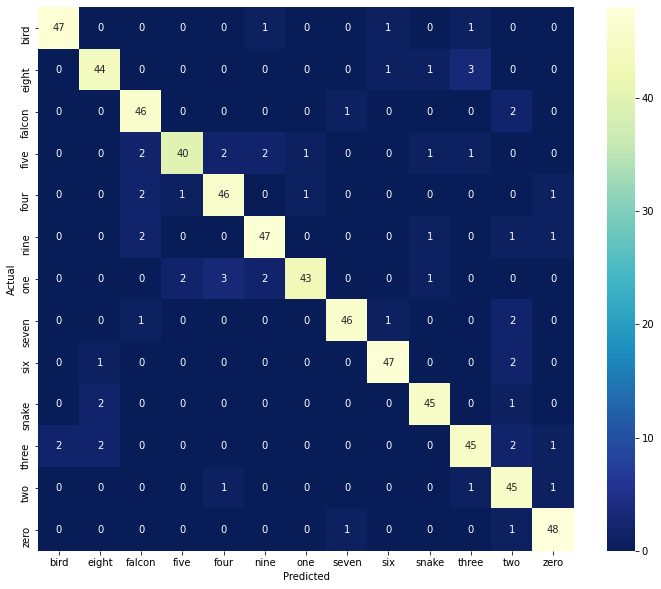

In [ ]:
# configuration
DROP_FLAG = False
FOLD10_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''
FOLD10 = '-10fold' if FOLD10_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}{FOLD10}'

get_score(PRED_FILE)

## 10-fold method | TM-5 | FM-5

              precision    recall  f1-score   support

        bird     0.9362    0.8800    0.9072        50
       eight     0.8846    0.9388    0.9109        49
      falcon     0.9375    0.9184    0.9278        49
        five     0.8936    0.8571    0.8750        49
        four     0.9556    0.8431    0.8958        51
        nine     0.8909    0.9423    0.9159        52
         one     0.9348    0.8431    0.8866        51
       seven     0.8545    0.9400    0.8952        50
         six     0.9583    0.9200    0.9388        50
       snake     0.9574    0.9375    0.9474        48
       three     0.8246    0.9038    0.8624        52
         two     0.7963    0.8958    0.8431        48
        zero     0.9583    0.9200    0.9388        50

    accuracy                         0.9029       649
   macro avg     0.9064    0.9031    0.9035       649
weighted avg     0.9064    0.9029    0.9034       649




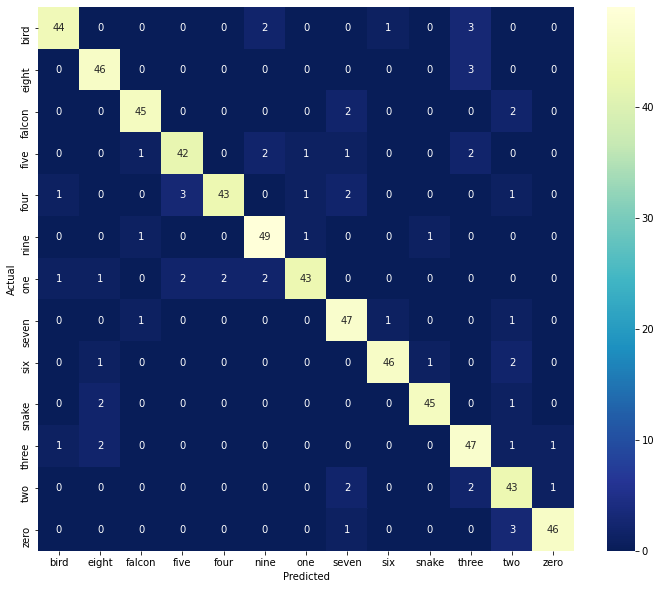

In [ ]:
# configuration
DROP_FLAG = False
FOLD10_FLAG = True
DROPOUT = '-dropout' if DROP_FLAG == True else ''
FOLD10 = '-10fold' if FOLD10_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 16, 'adagrad', 20
PRED_FILE = f'submission-SC-BiGru_lr-1e-03_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}{FOLD10}'

get_score(PRED_FILE)

## with noise injection

              precision    recall  f1-score   support

        bird     0.9778    0.8800    0.9263        50
       eight     0.8800    0.8980    0.8889        49
      falcon     0.9184    0.9184    0.9184        49
        five     0.9318    0.8367    0.8817        49
        four     0.9583    0.9020    0.9293        51
        nine     0.9400    0.9038    0.9216        52
         one     0.8654    0.8824    0.8738        51
       seven     0.8364    0.9200    0.8762        50
         six     0.9038    0.9400    0.9216        50
       snake     0.8980    0.9167    0.9072        48
       three     0.8654    0.8654    0.8654        52
         two     0.7500    0.8125    0.7800        48
        zero     0.9020    0.9200    0.9109        50

    accuracy                         0.8921       649
   macro avg     0.8944    0.8920    0.8924       649
weighted avg     0.8949    0.8921    0.8927       649




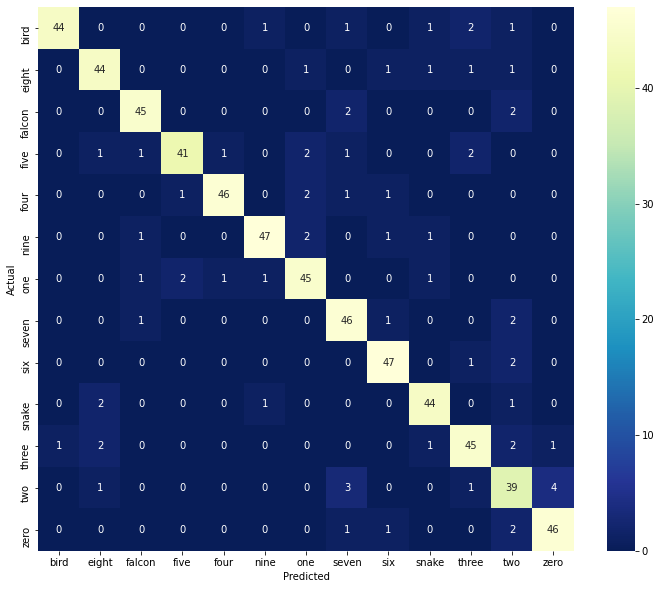

In [ ]:
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_noise_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9184    0.9000    0.9091        50
       eight     0.8958    0.8776    0.8866        49
      falcon     0.9000    0.9184    0.9091        49
        five     0.8864    0.7959    0.8387        49
        four     0.9020    0.9020    0.9020        51
        nine     0.9231    0.9231    0.9231        52
         one     0.8800    0.8627    0.8713        51
       seven     0.8868    0.9400    0.9126        50
         six     0.9592    0.9400    0.9495        50
       snake     0.9020    0.9583    0.9293        48
       three     0.9184    0.8654    0.8911        52
         two     0.7925    0.8750    0.8317        48
        zero     0.9400    0.9400    0.9400        50

    accuracy                         0.8998       649
   macro avg     0.9003    0.8999    0.8995       649
weighted avg     0.9008    0.8998    0.8998       649




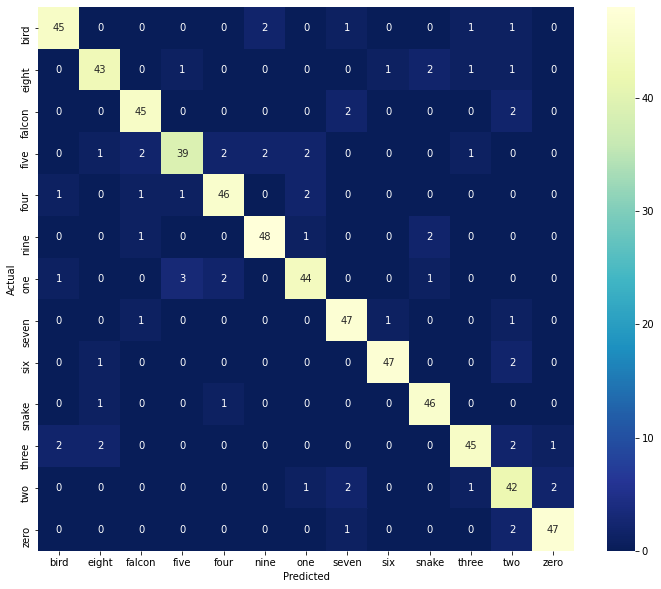

In [ ]:
# 0.2 noise
# configuration
DROP_FLAG = False
DROPOUT = '-dropout' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS = 256, 2, 32, 'adagrad', 30
PRED_FILE = f'submission-SC-BiGru_noise_0.2_TM-{TIME_MASK_PARAM}_FM-{FREQ_MASK_PARAM}_HS-{HIDDEN_SIZE}_NL-{NUM_LAYERS}_BS-{BATCH_SIZE}_OP-{OPTIM_NAME}_EP-{EPOCHS}{DROPOUT}'

get_score(PRED_FILE)

submission-noise-0.15_SC-BiGru_noise_TM-5_FM-5_HS-256_NL-2_BS-32_OP-adagrad_EP-30_drop-0.5

## Revamped with 0.15 noise and 0.5 dropout

              precision    recall  f1-score   support

        bird     0.9375    0.9000    0.9184        50
       eight     0.8627    0.8980    0.8800        49
      falcon     0.8654    0.9184    0.8911        49
        five     0.9500    0.7755    0.8539        49
        four     0.8980    0.8627    0.8800        51
        nine     0.9167    0.8462    0.8800        52
         one     0.8627    0.8627    0.8627        51
       seven     0.8246    0.9400    0.8785        50
         six     0.9574    0.9000    0.9278        50
       snake     0.8980    0.9167    0.9072        48
       three     0.8333    0.8654    0.8491        52
         two     0.8302    0.9167    0.8713        48
        zero     0.9400    0.9400    0.9400        50

    accuracy                         0.8875       649
   macro avg     0.8905    0.8879    0.8877       649
weighted avg     0.8905    0.8875    0.8876       649




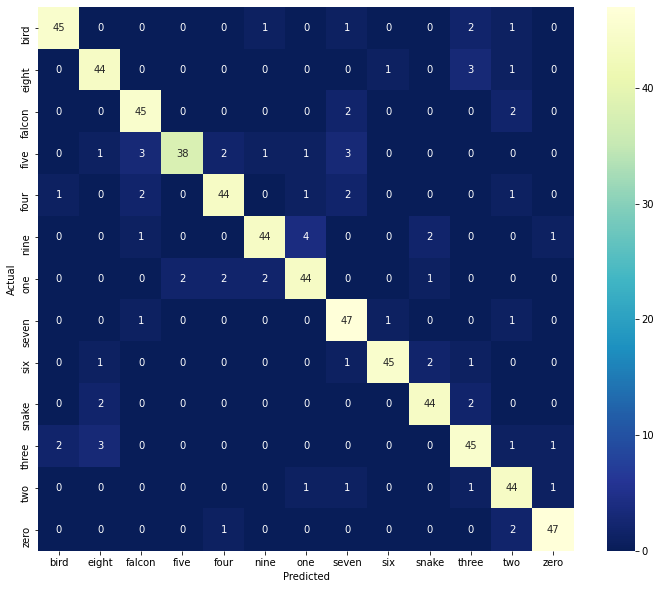

In [ ]:
# 0.15 noise
# configuration
DROP_FLAG = True
DROPOUT = '-drop' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS, DROP = 256, 2, 32, 'adagrad', 30, 0.5
PRED_FILE = f'submission-noise-0.15_SC-BiGru_noise_TM-5_FM-5_HS-256_NL-2_BS-32_OP-adagrad_EP-30_drop-0.5'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9375    0.9000    0.9184        50
       eight     0.8364    0.9388    0.8846        49
      falcon     0.8654    0.9184    0.8911        49
        five     0.9070    0.7959    0.8478        49
        four     0.9388    0.9020    0.9200        51
        nine     0.9388    0.8846    0.9109        52
         one     0.9020    0.9020    0.9020        51
       seven     0.8393    0.9400    0.8868        50
         six     0.9783    0.9000    0.9375        50
       snake     0.9130    0.8750    0.8936        48
       three     0.8980    0.8462    0.8713        52
         two     0.7895    0.9375    0.8571        48
        zero     0.9583    0.9200    0.9388        50

    accuracy                         0.8968       649
   macro avg     0.9002    0.8969    0.8969       649
weighted avg     0.9008    0.8968    0.8972       649




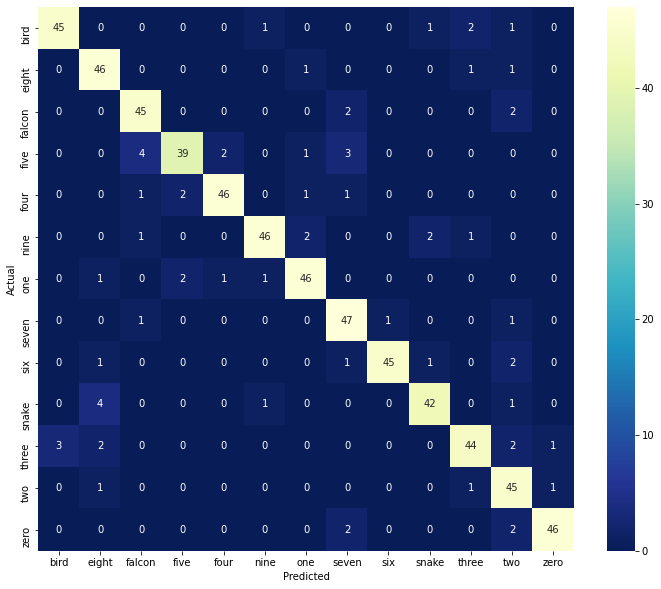

In [ ]:
# 0.15 noise
# configuration
DROP_FLAG = True
DROPOUT = '-drop' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 5, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS, DROP = 256, 2, 32, 'adam', 30, 0.5
PRED_FILE = f'submission-noise-0.15_SC-BiGru_noise_TM-5_FM-5_HS-256_NL-2_BS-32_OP-adam_EP-30_drop-0.5'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9200    0.9200    0.9200        50
       eight     0.8679    0.9388    0.9020        49
      falcon     0.8654    0.9184    0.8911        49
        five     0.8837    0.7755    0.8261        49
        four     0.9020    0.9020    0.9020        51
        nine     0.9020    0.8846    0.8932        52
         one     0.9149    0.8431    0.8776        51
       seven     0.8545    0.9400    0.8952        50
         six     0.9787    0.9200    0.9485        50
       snake     0.9149    0.8958    0.9053        48
       three     0.8824    0.8654    0.8738        52
         two     0.7636    0.8750    0.8155        48
        zero     0.9787    0.9200    0.9485        50

    accuracy                         0.8921       649
   macro avg     0.8945    0.8922    0.8922       649
weighted avg     0.8950    0.8921    0.8924       649




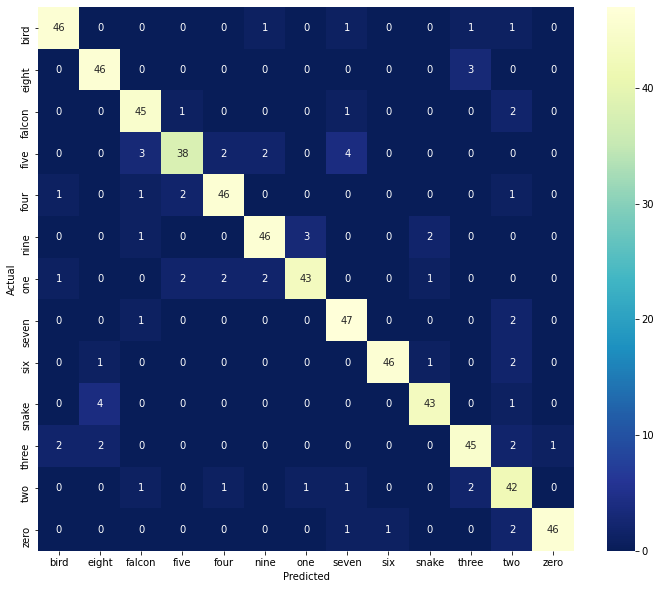

In [5]:
# 0.15 noise
# configuration
DROP_FLAG = True
DROPOUT = '-drop' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 10, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS, DROP = 256, 2, 32, 'adam', 30, 0.5
PRED_FILE = f'submission-noise-0.15_SC-BiGru_noise_TM-10_FM-5_HS-256_NL-2_BS-16_OP-adagrad_EP-30_drop-0.4'

get_score(PRED_FILE)

              precision    recall  f1-score   support

        bird     0.9000    0.9000    0.9000        50
       eight     0.8519    0.9388    0.8932        49
      falcon     0.8627    0.8980    0.8800        49
        five     0.9268    0.7755    0.8444        49
        four     0.9574    0.8824    0.9184        51
        nine     0.9600    0.9231    0.9412        52
         one     0.8679    0.9020    0.8846        51
       seven     0.8364    0.9200    0.8762        50
         six     0.9400    0.9400    0.9400        50
       snake     0.9149    0.8958    0.9053        48
       three     0.8367    0.7885    0.8119        52
         two     0.7736    0.8542    0.8119        48
        zero     0.9184    0.9000    0.9091        50

    accuracy                         0.8860       649
   macro avg     0.8882    0.8860    0.8859       649
weighted avg     0.8887    0.8860    0.8861       649




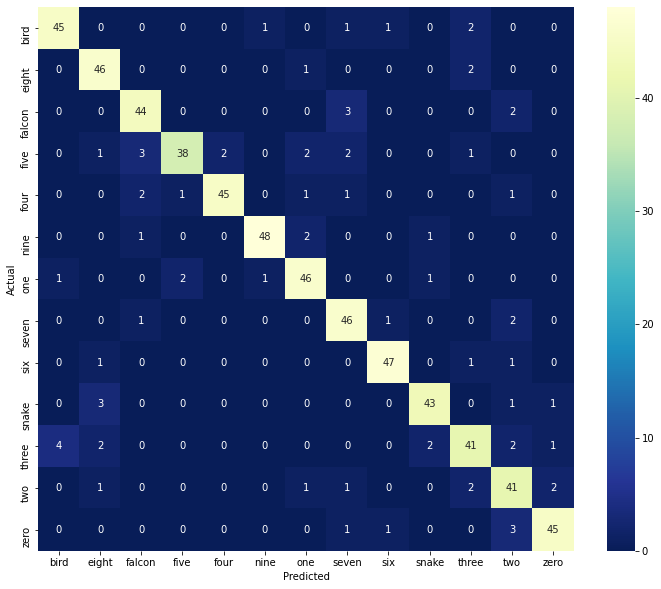

In [6]:
# 0.15 noise
# configuration
DROP_FLAG = True
DROPOUT = '-drop' if DROP_FLAG == True else ''

# ----- DECLARE HYPERPARAMETERS -----
TIME_MASK_PARAM, FREQ_MASK_PARAM = 10, 5
HIDDEN_SIZE, NUM_LAYERS, BATCH_SIZE, OPTIM_NAME, EPOCHS, DROP = 256, 2, 32, 'adam', 30, 0.5
PRED_FILE = f'submission-noise-0.15_SC-BiGru_noise_TM-10_FM-5_HS-256_NL-2_BS-16_OP-adamw_EP-30_drop-0.4'

get_score(PRED_FILE)